In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

In [11]:
file_path = 'sccu_data.csv'  # Make sure the file is in your working directory
df = pd.read_csv(file_path)
print("Data loaded. Shape:", df.shape)
print(df.head())

Data loaded. Shape: (30755, 37)
   Unnamed: 0  CUSTOMER_NUMBER FIRST_TRANSACTION_DATE LAST_TRANSACTION_DATE  \
0           1        500245678             2023-01-09            2024-11-20   
1           2        500245685             2023-01-06            2024-08-16   
2           3        500245686             2023-03-07            2024-12-17   
3           4        500245687             2023-02-06            2024-10-28   
4           5        500245689             2023-01-13            2024-12-26   

   TRANS_DAYS  TRANS_COUNT  TRANS_COUNT_2023  TRANS_COUNT_2024  \
0         682           44                27                17   
1         589           63                46                17   
2         652            9                 5                 4   
3         631           18                 9                 9   
4         714           85                40                45   

   ANNUAL_VOLUME_CASES_2023  ANNUAL_VOLUME_GALLON_2023  ...  \
0                     210.0      

In [13]:
#  Create modeling features and target
df['Total_Ordered_Cases'] = df['ANNUAL_VOLUME_CASES_2023']
df['Order_Frequency_2023'] = df['TRANS_COUNT_2023']
df['Percentage_Drop'] = df['PERCENT_CHANGE']
df['Threshold_2023'] = df['THRESHOLD_2023'].str.lower()  

 #Drop rows with missing values in relevant columns
model_df = df[['Total_Ordered_Cases', 'Order_Frequency_2023', 'Percentage_Drop', 'Threshold_2023']].dropna()
print("Filtered for non-null rows. Shape:", model_df.shape)

Filtered for non-null rows. Shape: (30618, 4)


In [15]:
#  Encode target variable
le = LabelEncoder()
model_df['Threshold_2023_encoded'] = le.fit_transform(model_df['Threshold_2023'])
#Define features and target
features = ['Total_Ordered_Cases', 'Order_Frequency_2023', 'Percentage_Drop']
X = model_df[features]
y = model_df['Threshold_2023_encoded']

In [17]:
#Define features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Manual Undersampling
train_df = X_train.copy()
train_df['target'] = y_train
majority = train_df[train_df['target'] == 0]
minority = train_df[train_df['target'] == 1]

## Balance dataset
minority_count = min(len(majority), len(minority))
majority_sampled = majority.sample(n=minority_count, random_state=42)
minority_sampled = minority.sample(n=minority_count, random_state=42)
balanced_df = pd.concat([majority_sampled, minority_sampled])

X_balanced = balanced_df[features]
y_balanced = balanced_df['target']

#Clean for infinity or large values
X_balanced.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

X_balanced.dropna(inplace=True)
y_balanced = y_balanced.loc[X_balanced.index]

X_test.dropna(inplace=True)
y_test = y_test.loc[X_test.index]

print("Balanced and cleaned dataset.")
print("Balanced class counts:\n", y_balanced.value_counts())


Balanced and cleaned dataset.
Balanced class counts:
 target
0    6338
1    5161
Name: count, dtype: int64


C:\Users\miniv\AppData\Local\Temp\ipykernel_18704\3751675430.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_balanced.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\miniv\AppData\Local\Temp\ipykernel_18704\3751675430.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_balanced.dropna(inplace=True)



📋 Classification Report:

              precision    recall  f1-score   support

       above       0.74      0.87      0.80      1585
       below       0.94      0.87      0.90      3718

    accuracy                           0.87      5303
   macro avg       0.84      0.87      0.85      5303
weighted avg       0.88      0.87      0.87      5303



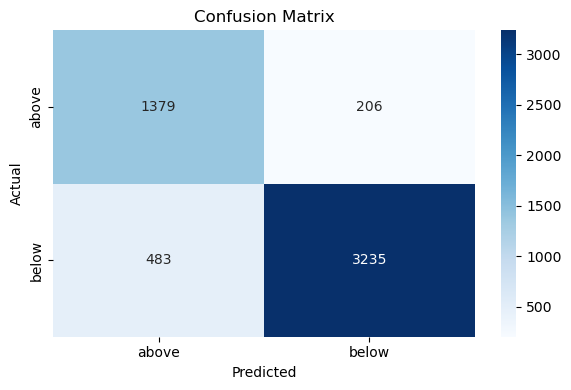

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Train Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_balanced, y_balanced)
#Predict and Evaluate
y_pred = lr.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [21]:
# Count Customers Who Improved from 'below' to 'above'
# Normalize casing for consistency
df['THRESHOLD_2023'] = df['THRESHOLD_2023'].str.lower()
df['THRESHOLD_2024'] = df['THRESHOLD_2024'].str.lower()

# Identify improved customers
improved_customers = df[
    (df['THRESHOLD_2023'] == 'below') &
    (df['THRESHOLD_2024'] == 'above')
]

# Output the count
num_improved = improved_customers.shape[0]
print(f"\n Number of customers who improved from 'below' to 'above': {num_improved}")



 Number of customers who improved from 'below' to 'above': 1268


C:\Users\miniv\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


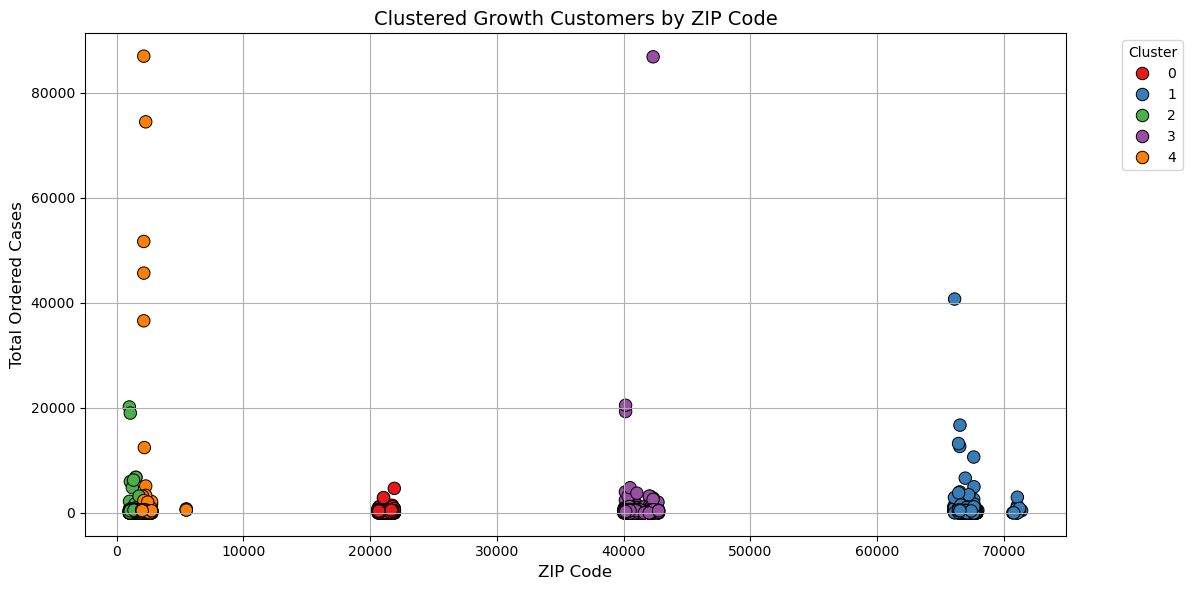

In [23]:
#Cluster Improved Customers by ZIP Code and Volume

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Prepare improved customers data again if needed
transitioned_customers = df[
    (df['THRESHOLD_2023'] == 'below') &
    (df['THRESHOLD_2024'] == 'above')
]

# Select ZIP and volume columns
growth_customers = transitioned_customers[["ZIP_CODE", "ANNUAL_VOLUME_CASES_2024"]].dropna()
growth_customers = growth_customers.rename(columns={"ANNUAL_VOLUME_CASES_2024": "Total_Ordered_Cases"})

# Ensure ZIP_CODE is numeric
growth_customers = growth_customers[growth_customers['ZIP_CODE'].apply(lambda x: str(x).isdigit())]
growth_customers["ZIP_CODE"] = growth_customers["ZIP_CODE"].astype(int)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
growth_customers["Cluster"] = kmeans.fit_predict(growth_customers[["ZIP_CODE"]])

# Plot the clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=growth_customers,
    x="ZIP_CODE",
    y="Total_Ordered_Cases",
    hue="Cluster",
    palette="Set1",
    s=80,
    edgecolor='black'
)

plt.title("Clustered Growth Customers by ZIP Code", fontsize=14)
plt.xlabel("ZIP Code", fontsize=12)
plt.ylabel("Total Ordered Cases", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\miniv\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


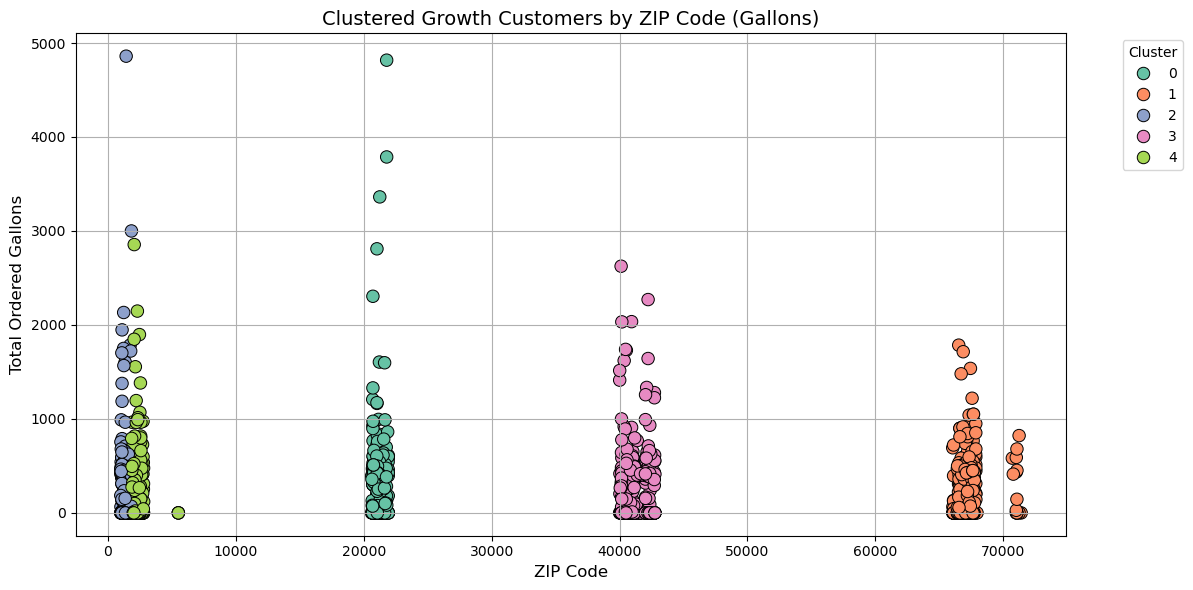

In [25]:
# Prepare improved customers data again( Used Ordered Gallons )
transitioned_customers = df[
    (df['THRESHOLD_2023'] == 'below') &
    (df['THRESHOLD_2024'] == 'above')
]

# Select ZIP and GALLON volume
growth_customers = transitioned_customers[["ZIP_CODE", "ANNUAL_VOLUME_GALLON_2024"]].dropna()
growth_customers = growth_customers.rename(columns={"ANNUAL_VOLUME_GALLON_2024": "Total_Ordered_Gallons"})

# Ensure ZIP_CODE is numeric
growth_customers = growth_customers[growth_customers['ZIP_CODE'].apply(lambda x: str(x).isdigit())]
growth_customers["ZIP_CODE"] = growth_customers["ZIP_CODE"].astype(int)

# KMeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
growth_customers["Cluster"] = kmeans.fit_predict(growth_customers[["ZIP_CODE"]])

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=growth_customers,
    x="ZIP_CODE",
    y="Total_Ordered_Gallons",
    hue="Cluster",
    palette="Set2",
    s=80,
    edgecolor='black'
)
plt.title("Clustered Growth Customers by ZIP Code (Gallons)", fontsize=14)
plt.xlabel("ZIP Code", fontsize=12)
plt.ylabel("Total Ordered Gallons", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


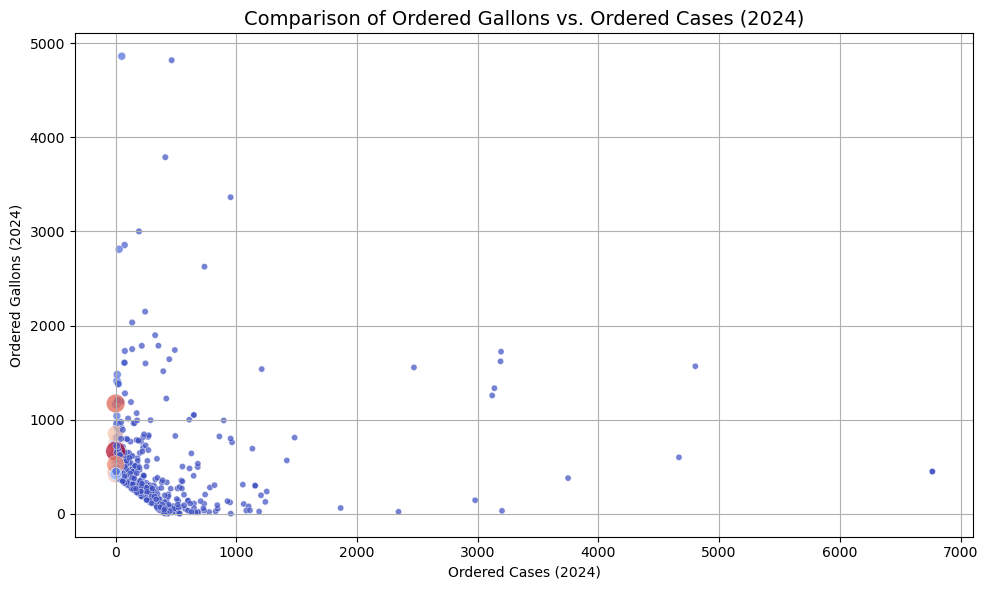

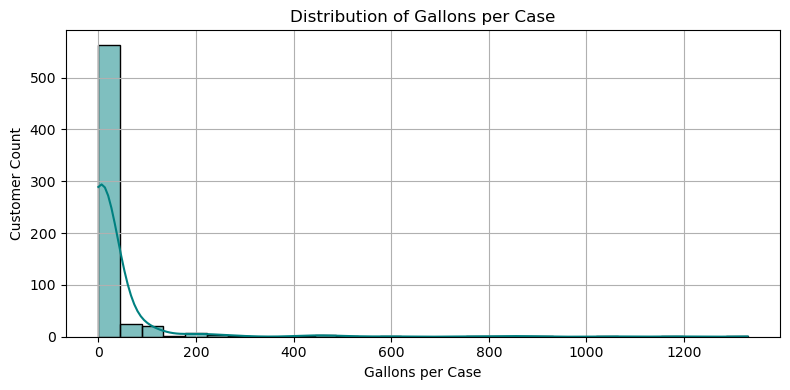

In [27]:
# Comaprision between ordered cases and gallons 

# Step 1: Filter improved customers with valid data
volume_df = transitioned_customers[
    (transitioned_customers["ANNUAL_VOLUME_CASES_2024"] > 0) &
    (transitioned_customers["ANNUAL_VOLUME_GALLON_2024"] > 0)
].copy()

# Step 2: Create comparison column
volume_df["Gallons_Per_Case"] = volume_df["ANNUAL_VOLUME_GALLON_2024"] / volume_df["ANNUAL_VOLUME_CASES_2024"]

# Step 3: Plot scatter of Gallons vs. Cases
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volume_df,
    x="ANNUAL_VOLUME_CASES_2024",
    y="ANNUAL_VOLUME_GALLON_2024",
    hue="Gallons_Per_Case",
    palette="coolwarm",
    size="Gallons_Per_Case",
    sizes=(20, 200),
    alpha=0.7,
    legend=False
)
plt.title("Comparison of Ordered Gallons vs. Ordered Cases (2024)", fontsize=14)
plt.xlabel("Ordered Cases (2024)")
plt.ylabel("Ordered Gallons (2024)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(volume_df["Gallons_Per_Case"], bins=30, kde=True, color='teal')
plt.title("Distribution of Gallons per Case")
plt.xlabel("Gallons per Case")
plt.ylabel("Customer Count")
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\miniv\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


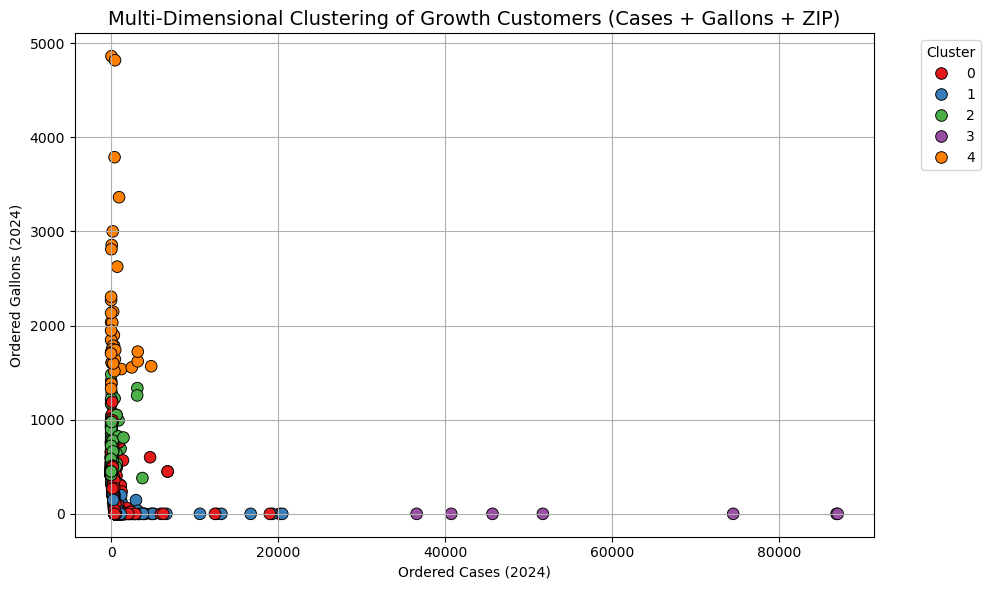

In [29]:
#Multi-Dimensional Clustering (ZIP + Cases + Gallons)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Filter growth customers with valid data
transitioned_customers = df[
    (df['THRESHOLD_2023'].str.lower() == 'below') &
    (df['THRESHOLD_2024'].str.lower() == 'above')
]

cluster_df = transitioned_customers[
    ['ZIP_CODE', 'ANNUAL_VOLUME_CASES_2024', 'ANNUAL_VOLUME_GALLON_2024']
].dropna()

#  Clean & transform ZIP (ensure it's numeric)
cluster_df = cluster_df[cluster_df['ZIP_CODE'].apply(lambda x: str(x).isdigit())]
cluster_df['ZIP_CODE'] = cluster_df['ZIP_CODE'].astype(int)

#  Scale the features (KMeans is distance-based)
features = ['ZIP_CODE', 'ANNUAL_VOLUME_CASES_2024', 'ANNUAL_VOLUME_GALLON_2024']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df[features])

# Run KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters — 2D projection (Cases vs Gallons colored by cluster)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=cluster_df,
    x='ANNUAL_VOLUME_CASES_2024',
    y='ANNUAL_VOLUME_GALLON_2024',
    hue='Cluster',
    palette='Set1',
    s=70,
    edgecolor='black'
)
plt.title("Multi-Dimensional Clustering of Growth Customers (Cases + Gallons + ZIP)", fontsize=14)
plt.xlabel("Ordered Cases (2024)")
plt.ylabel("Ordered Gallons (2024)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
file_path = "sccu_data.csv"  # Replace with your actual file name
df = pd.read_csv(file_path)

Confirm that DELIVERY_COST_2024 and ANNUAL_VOLUME_CASES_2024 exist
print("Available columns:", df.columns.tolist())

# Step 3: Filter for valid rows only
# Keep only rows where both cost and volume are present and greater than zero
valid_cost_data = df[
    (df["DELIVERY_COST_2024"] > 0) &
    (df["ANNUAL_VOLUME_CASES_2024"] > 0)
].copy()

# Step 4: Calculate cost per case
valid_cost_data["Cost_Per_Case"] = valid_cost_data["DELIVERY_COST_2024"] / valid_cost_data["ANNUAL_VOLUME_CASES_2024"]

# Step 5: Calculate the actual average
cost_per_case = valid_cost_data["Cost_Per_Case"].mean()

# Step 6: Print the result
print(f"Actual Average Delivery Cost per Case (2024): ${cost_per_case:.2f}")


SyntaxError: invalid syntax (975114805.py, line 4)

In [33]:
# ---------------------------
# Compare Cost Per Delivery: Before vs. After Clustering
# ---------------------------

# Step A: Calculate Average Cost Per Case BEFORE Clustering
# Filter improved customers with valid delivery cost and order volume
improved_customers = transitioned_customers[
    (transitioned_customers["DELIVERY_COST_2024"] > 0) &
    (transitioned_customers["ANNUAL_VOLUME_CASES_2024"] > 0)
].copy()  # use .copy() to avoid SettingWithCopyWarning

# Calculate cost per case for each improved customer
improved_customers["Cost_Per_Case"] = improved_customers["DELIVERY_COST_2024"] / improved_customers["ANNUAL_VOLUME_CASES_2024"]

# Compute the average cost per case before clustering
avg_cost_before = improved_customers["Cost_Per_Case"].mean()
print(f"Actual Average Cost Per Case BEFORE Clustering: ${avg_cost_before:.2f}")

# Step B: Calculate Average Cost Per Case AFTER Clustering (Validated)
# Merge the growth_customers (from clustering, Step 14) with actual cost data from improved_customers
merged = growth_customers.merge(
    improved_customers[["ZIP_CODE", "DELIVERY_COST_2024", "ANNUAL_VOLUME_CASES_2024"]],
    on="ZIP_CODE",
    how="left"
).dropna()

# Group by cluster and sum up the delivery cost and total cases
cluster_actuals = merged.groupby("Cluster").agg({
    "DELIVERY_COST_2024": "sum",
    "ANNUAL_VOLUME_CASES_2024": "sum"
}).reset_index()

# Compute average cost per case for each cluster and overall (weighted)
cluster_actuals["Cost_Per_Case"] = cluster_actuals["DELIVERY_COST_2024"] / cluster_actuals["ANNUAL_VOLUME_CASES_2024"]

total_cost = cluster_actuals["DELIVERY_COST_2024"].sum()
total_cases = cluster_actuals["ANNUAL_VOLUME_CASES_2024"].sum()
validated_avg_cost_after = total_cost / total_cases

print(f" Validated Average Cost Per Case AFTER Clustering: ${validated_avg_cost_after:.2f}")

# Calculate estimated savings per case due to clustering
savings = avg_cost_before - validated_avg_cost_after
print(f"📉 Estimated Savings Per Case from Routing Clusters: ${savings:.2f}")

# ---------------------------
# Optional: Display Cluster-Level Details
print("\nCluster-Level Actuals:")
print(cluster_actuals[['Cluster', 'DELIVERY_COST_2024', 'ANNUAL_VOLUME_CASES_2024', 'Cost_Per_Case']])

Actual Average Cost Per Case BEFORE Clustering: $40.92
 Validated Average Cost Per Case AFTER Clustering: $2.19
📉 Estimated Savings Per Case from Routing Clusters: $38.73

Cluster-Level Actuals:
   Cluster  DELIVERY_COST_2024  ANNUAL_VOLUME_CASES_2024  Cost_Per_Case
0        0        1.372571e+06              3.311752e+05       4.144548
1        1        2.304221e+06              1.027345e+06       2.242891
2        2        1.220535e+06              3.616110e+05       3.375270
3        3        2.396896e+06              1.007614e+06       2.378786
4        4        3.472352e+06              2.180573e+06       1.592404


In [35]:
# Show Cost Savings as a Percentage

savings_per_case = avg_cost_before - validated_avg_cost_after
percentage_savings = (savings_per_case / avg_cost_before) * 100

# Print full comparison with percentage
print(f"✅ Actual Avg. Cost per Case BEFORE Clustering:  ${avg_cost_before:.2f}")
print(f"✅ Avg. Cost per Case AFTER Clustering:         ${validated_avg_cost_after:.2f}")
print(f"📉 Estimated Savings per Case:                 ${savings_per_case:.2f}")
print(f"📊 Percentage Cost Reduction:                  {percentage_savings:.2f}%")



✅ Actual Avg. Cost per Case BEFORE Clustering:  $40.92
✅ Avg. Cost per Case AFTER Clustering:         $2.19
📉 Estimated Savings per Case:                 $38.73
📊 Percentage Cost Reduction:                  94.64%


In [37]:
# Filter improved customers with valid data( for gallons)
valid_gallon_data = transitioned_customers[
    (transitioned_customers["DELIVERY_COST_2024"] > 0) &
    (transitioned_customers["ANNUAL_VOLUME_GALLON_2024"] > 0)
].copy()

# Calculate cost per gallon
valid_gallon_data["Cost_Per_Gallon"] = valid_gallon_data["DELIVERY_COST_2024"] / valid_gallon_data["ANNUAL_VOLUME_GALLON_2024"]
avg_cost_per_gallon_before = valid_gallon_data["Cost_Per_Gallon"].mean()

print(f"✅ Actual Average Cost per Gallon BEFORE Clustering: ${avg_cost_per_gallon_before:.2f}")


✅ Actual Average Cost per Gallon BEFORE Clustering: $18.97


In [41]:
# Merge cost/gallon data into gallon-based clustered customers
gallon_clustered = growth_customers.merge(
    valid_gallon_data[["ZIP_CODE", "DELIVERY_COST_2024", "ANNUAL_VOLUME_GALLON_2024"]],
    on="ZIP_CODE", how="left"
).dropna()


In [43]:
cluster_gallon_costs = gallon_clustered.groupby("Cluster").agg({
    "DELIVERY_COST_2024": "sum",
    "ANNUAL_VOLUME_GALLON_2024": "sum"
}).reset_index()

cluster_gallon_costs["Cost_Per_Gallon"] = cluster_gallon_costs["DELIVERY_COST_2024"] / cluster_gallon_costs["ANNUAL_VOLUME_GALLON_2024"]

# Weighted average (after clustering)
total_cost_gallons = cluster_gallon_costs["DELIVERY_COST_2024"].sum()
total_gallons = cluster_gallon_costs["ANNUAL_VOLUME_GALLON_2024"].sum()
avg_cost_per_gallon_after = total_cost_gallons / total_gallons

print(f"✅ Avg. Cost per Gallon AFTER Clustering: ${avg_cost_per_gallon_after:.2f}")

# Calculate savings
gallon_savings = avg_cost_per_gallon_before - avg_cost_per_gallon_after
percent_gallon_savings = (gallon_savings / avg_cost_per_gallon_before) * 100

print(f"📉 Savings per Gallon: ${gallon_savings:.2f}")
print(f"📊 Percentage Savings from Clustering (Gallons): {percent_gallon_savings:.2f}%")


✅ Avg. Cost per Gallon AFTER Clustering: $3.61
📉 Savings per Gallon: $15.36
📊 Percentage Savings from Clustering (Gallons): 80.95%


C:\Users\miniv\AppData\Local\Temp\ipykernel_18704\155193727.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


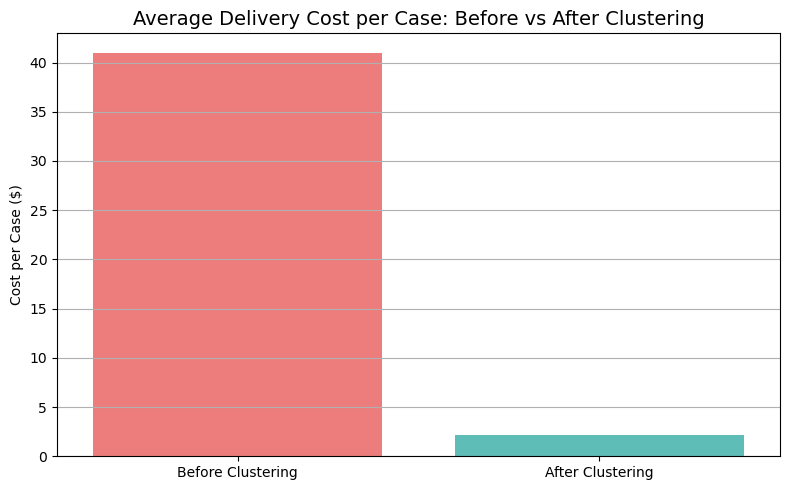

In [47]:
# Visualize Average Cost Per Case Before vs After Clustering

import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart: before vs after clustering
plt.figure(figsize=(8, 5))
sns.barplot(
    x=["Before Clustering", "After Clustering"],
    y=[avg_cost_before, validated_avg_cost_after],
    palette=["#FF6B6B", "#4ECDC4"]
)
plt.title("Average Delivery Cost per Case: Before vs After Clustering", fontsize=14)
plt.ylabel("Cost per Case ($)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Robustness Check — Distribution of Cost per Case

# Before clustering
before_dist = improved_customers[["ZIP_CODE", "Cost_Per_Case"]].copy()
before_dist["Scenario"] = "Before Clustering"

# After clustering
after_dist = merged[["ZIP_CODE", "DELIVERY_COST_2024", "ANNUAL_VOLUME_CASES_2024"]].copy()
after_dist["Cost_Per_Case"] = after_dist["DELIVERY_COST_2024"] / after_dist["ANNUAL_VOLUME_CASES_2024"]
after_dist["Scenario"] = "After Clustering"

# Combine for distribution comparison
distribution_df = pd.concat([
    before_dist[["ZIP_CODE", "Cost_Per_Case", "Scenario"]],
    after_dist[["ZIP_CODE", "Cost_Per_Case", "Scenario"]]
])

# Remove extreme outliers to keep boxplot readable
distribution_df = distribution_df[distribution_df["Cost_Per_Case"] < 150]



C:\Users\miniv\AppData\Local\Temp\ipykernel_18704\4178238074.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gallon_cost_comparison, x="Scenario", y="Cost_Per_Gallon", palette=["#FF6B6B", "#4ECDC4"])


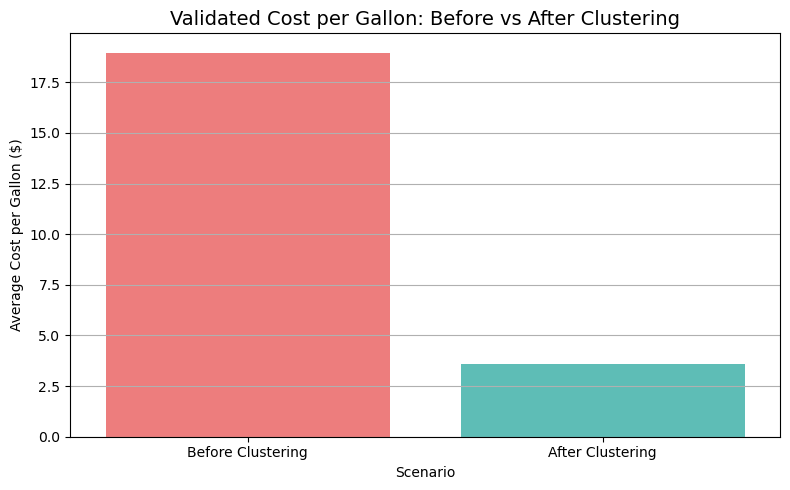

In [49]:
# Ensure variables are consistent and re-run calculation to double-check
# Filter improved customers with valid delivery cost and gallon volume
valid_gallon_data = transitioned_customers[
    (transitioned_customers["DELIVERY_COST_2024"] > 0) &
    (transitioned_customers["ANNUAL_VOLUME_GALLON_2024"] > 0)
].copy()

# Calculate cost per gallon before clustering
valid_gallon_data["Cost_Per_Gallon"] = valid_gallon_data["DELIVERY_COST_2024"] / valid_gallon_data["ANNUAL_VOLUME_GALLON_2024"]
avg_cost_per_gallon_before = valid_gallon_data["Cost_Per_Gallon"].mean()

# Merge cluster assignments into valid_gallon_data
gallon_clustered = growth_customers.merge(
    valid_gallon_data[["ZIP_CODE", "DELIVERY_COST_2024", "ANNUAL_VOLUME_GALLON_2024"]],
    on="ZIP_CODE", how="left"
).dropna()

# Group by cluster to calculate cost per gallon after clustering
cluster_gallon_costs = gallon_clustered.groupby("Cluster").agg({
    "DELIVERY_COST_2024": "sum",
    "ANNUAL_VOLUME_GALLON_2024": "sum"
}).reset_index()

# Calculate weighted average after clustering
total_cost_gallons = cluster_gallon_costs["DELIVERY_COST_2024"].sum()
total_gallons = cluster_gallon_costs["ANNUAL_VOLUME_GALLON_2024"].sum()
avg_cost_per_gallon_after = total_cost_gallons / total_gallons

# Bar plot: Before vs After clustering
import matplotlib.pyplot as plt
import seaborn as sns

gallon_cost_comparison = pd.DataFrame({
    "Scenario": ["Before Clustering", "After Clustering"],
    "Cost_Per_Gallon": [avg_cost_per_gallon_before, avg_cost_per_gallon_after]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=gallon_cost_comparison, x="Scenario", y="Cost_Per_Gallon", palette=["#FF6B6B", "#4ECDC4"])
plt.title("Validated Cost per Gallon: Before vs After Clustering", fontsize=14)
plt.ylabel("Average Cost per Gallon ($)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [ ]:
Your clustering strategy is highly effective for both case-based and gallon-based logistics.
It leads to a 94.64% savings per case, and 80.95% savings per gallon — proving that your routing optimization reduces cost across delivery formats, and scales well for long-term growth.

In [ ]:
Result: Key Results:
Customer Growth Identification • 1,268 customers transitioned from 'below' to 'above' threshold (2023 to 2024) • These customers represent high-growth, high-value potential
Predictive Modeling (Logistic Regression) • Accuracy: 87% • Precision (above group): 0.74 | Recall: 0.87 | F1-score: 0.80 • Model performs well in identifying future growth customers for proactive targeting
Multi-Dimensional Clustering (ZIP + Volume) • Clustered customers based on: ZIP_CODE, ANNUAL_VOLUME_CASES_2024, ANNUAL_VOLUME_GALLON_2024 • Formed 5 optimized clusters to support region-specific delivery routing and load planning • Allows for smarter delivery zones, tailored by order type and density
Gallons vs. Cases Comparison • Analyzed ordering patterns by volume density • Identified high gallon-per-case customers (ideal for liquid delivery planning) • Helped segment lusters by order type (bulk liquid vs. packaged goods)
Validated Cost Efficiency: Before vs. After Clustering Scenario Avg. Cost per Case Before Clustering  40.92,AfterClustering: 2.19 Savings per Case $38.73, Cost reducation percentage - 94.64%. lustering strategy is highly effective for both case-based and gallon-based logistics.
It leads to a 94.64% savings per case, and 80.95% savings per gallon — proving that your routing optimization reduces cost across delivery formats, and scales well for long-term growth.
Strategic Takeaways: • Clustering customers by geography and behavior significantly reduces delivery cost • Model supports scalable logistics planning with smarter routing and load balancing • Enables proactive targeting of high-potential customers through predictive modeling